In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#import matplotlib.pyplot as plt
#from collections import Counter
#from collections import defaultdict


In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from surprise import SVD
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/grive')

Drive already mounted at /content/grive; to attempt to forcibly remount, call drive.mount("/content/grive", force_remount=True).


In [ ]:
# Reading in data from each .csv file and concatenating them all together into a single dataframe

list = []
filenames = ['/content/grive/MyDrive/phone_user_review_file_1.csv','/content/grive/MyDrive/phone_user_review_file_2.csv', '/content/grive/MyDrive/phone_user_review_file_3.csv', '/content/grive/MyDrive/phone_user_review_file_4.csv', '/content/grive/MyDrive/phone_user_review_file_5.csv', '/content/grive/MyDrive/phone_user_review_file_6.csv']
for file in filenames:
    csv_file = pd.read_csv(file, index_col=None, header=0, encoding= 'latin')
    print(csv_file.shape)
    list.append(csv_file)

df_phones = pd.concat(list, axis=0, ignore_index=True)
print("\n\n")
print("Shape of final Dataframe after concatenating data from all csv files into one Dataframe", df_phones.shape)

(374910, 11)
(114925, 11)
(312961, 11)
(98284, 11)
(350216, 11)
(163837, 11)



Shape of final Dataframe after concatenating data from all csv files into one Dataframe (1415133, 11)


In [ ]:
# Analysing Data

print(df_phones.head(100).to_string())

                         phone_url       date lang country            source               domain  score  score_max                                                                                                                                                                                                                                                                                                  extract               author                                                                                      product
0   /cellphones/samsung-galaxy-s8/   5/2/2017   en      us  Verizon Wireless  verizonwireless.com   10.0       10.0                       As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far. I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced. The battery life is amazing.           CarolAnn35                                        

In [ ]:
df_phones.dtypes

phone_url     object
date          object
lang          object
country       object
source        object
domain        object
score        float64
score_max    float64
extract       object
author        object
product       object
dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


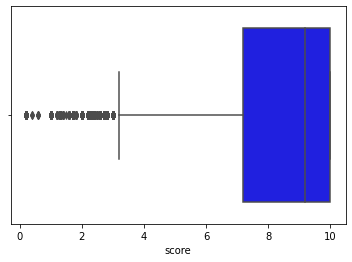

In [ ]:
sns.boxplot(df_phones['score'],color='blue')

In [ ]:
df_phones['score'].value_counts()

10.0    656239
8.0     296018
2.0     128485
6.0     116616
4.0      72462
         ...  
0.4          2
6.1          1
1.5          1
8.9          1
4.9          1
Name: score, Length: 86, dtype: int64

Inference from Data Analysed Above
------------------------------------
1. The scores in the dataset are heavily concentrated between 7.0 and 10.0 with median being somewhere around 9.2 rating and mean being somewhere close to 8.2. 2. The data based on ratings is heavily skewed to the left and most values in the dataset is 8 and above.
3. All the features in the dataset are categorical except 'score' & 'score_max'
4. All features are here irrelevant in the current problem statement except 'product', 'author' and 'score'.

In [ ]:
# Rounding off the values from 'score' column

df_phones['score'] = round(df_phones['score'])

In [ ]:
print(df_phones.head(200).to_string())

                          phone_url       date lang country            source               domain  score  score_max                                                                                                                                                                                                                                                                                                          extract                author                                                                                      product
0    /cellphones/samsung-galaxy-s8/   5/2/2017   en      us  Verizon Wireless  verizonwireless.com   10.0       10.0                               As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far. I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced. The battery life is amazing.            CarolAnn35                    

In [ ]:
# Checking for null values

df_phones.isnull().sum()


phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score        63489
score_max    63489
extract      19361
author       63202
product          1
dtype: int64

In [ ]:
# Total Rows with null values in the dataset

null = df_phones[df_phones.isnull().any(axis=1)]
null.shape

(139216, 11)

In [ ]:
# Dropping all rows with null values from the dataset since it doesnt make sense to impute such huge number of null values while building a recommendation system/dropping the columns of interest like author, score etc 

df_phones = df_phones.dropna()
print(df_phones.shape)


(1275917, 11)


In [ ]:
#Total number of rows that are duplicated in the entire dataset

df_phones.duplicated().value_counts()

False    1271437
True        4480
dtype: int64

In [ ]:
# Subset of dataset with duplicated observations

duplicate = df_phones[df_phones.duplicated()]

In [ ]:
duplicate.head(400)

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
342,/cellphones/samsung-galaxy-s8/,4/26/2017,nl,nl,Coolblue,coolblue.nl,10.0,10.0,Ik vind het tot nu toe een heel erg aangenaam ...,Stefanie Hinneman,Samsung Galaxy S8 Zwart
343,/cellphones/samsung-galaxy-s8/,4/26/2017,nl,nl,Coolblue,coolblue.nl,10.0,10.0,Ik vind het tot nu toe een heel erg aangenaam ...,Stefanie Hinneman,Samsung Galaxy S8 Zwart
371,/cellphones/samsung-galaxy-s8/,4/25/2017,nl,nl,Coolblue,coolblue.nl,10.0,10.0,Tot nu toe in de eerste dagen weinig tot geen ...,Robin Winckens,Samsung Galaxy S8 Zwart
452,/cellphones/samsung-galaxy-s8/,4/25/2017,nl,nl,Coolblue,coolblue.nl,10.0,10.0,Wat een huge scherm!,B Yapar,Samsung Galaxy S8 Zwart
3718,/cellphones/samsung-galaxy-s6-edgeplus/,10/4/2015,en,us,Amazon,amazon.com,10.0,10.0,"For readers, my opinions on this device (ATT 3...",FrozenCloud,"Samsung Galaxy S6 Edge+, Black 64GB (Verizon W..."
...,...,...,...,...,...,...,...,...,...,...,...
143501,/cellphones/samsung-galaxy-a5-2016/,10/1/2016,tr,tr,Samsung,samsung.com,8.0,10.0,BU ÃRÃN FÄ°YATINA GÃRE MÃKEMMEL BENCE HÄ°Ã...,SAMSUNG_7082,Samsung Galaxy A5 (2016)
143614,/cellphones/samsung-galaxy-a5-2016/,9/10/2016,pt,br,Bondfaro,bondfaro.com.br,8.0,10.0,Este aparelho possui um design bastante atrati...,e-bit,Smartphone Samsung Galaxy A5 SM-A510M
143671,/cellphones/samsung-galaxy-a5-2016/,8/30/2016,tr,tr,Samsung,samsung.com,8.0,10.0,A5 2016 modeli kullanicisiyim. Cok memnundum f...,A52016 kullanicisi,Samsung Galaxy A5 (2016)
144308,/cellphones/samsung-galaxy-a5-2016/,6/11/2016,pt,br,Bondfaro,bondfaro.com.br,8.0,10.0,"Excelente aparelho, mas parece ser frÃ¡gil.",e-bit,Smartphone Samsung Galaxy A5 SM-A510M


In [ ]:
# Dropping duplicate rows

df_phones.drop_duplicates(inplace = True)
df_phones.shape

(1271437, 11)

In [ ]:
# Taking a sample of 1000000 datapoints from the actual dataset

df_phones_sample = df_phones.sample(n = 1000000, random_state = 612)
df_phones_sample.shape

(1000000, 11)

In [ ]:
# Columns in sample dataset

df_phones_sample.columns

Index(['phone_url', 'date', 'lang', 'country', 'source', 'domain', 'score',
       'score_max', 'extract', 'author', 'product'],
      dtype='object')

In [ ]:
# Dropping insignificant columns/features from the dataset

df_phones_sample = df_phones_sample.drop(['phone_url', 'date', 'lang', 'country', 'source', 'domain', 'score_max', 'extract'], axis=1)
df_phones_sample.head()

,score,author,product
510111,10.0,KHILESH KUMAR VERMA,"Lenovo Vibe K5 (Gold, VoLTE update)"
104794,8.0,Evyta,Samsung Galaxy S6
1222473,8.0,VanRaZor,Sony Ericsson K810i
452910,6.0,ruga,Sony Xperia Z2 (Black)
16933,10.0,einer Kundin,"Samsung Galaxy S7 edge Smartphone, 13,9 cm (5,..."


# The most highly rated mobile phones

In [ ]:
# The most highly rated mobile phones in the decreasing order

df_phones_sample.groupby('product')['score'].mean().sort_values(ascending=False).head(10000)

product
'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...                                                               10.000000
Motorola K1 On Vodafone Pay As You Go                                                                                                                                                    10.000000
Motorola Droid RAZR (Red)                                                                                                                                                                10.000000
Motorola Droid RAZR 16GB XT912 4G LTE Purple - Verizon                                                                                                                                   10.000000
Motorola Droid RAZR HD - 16GB - Black (Verizon) Smartphone                                                                                                                               10.000000
                 

In [ ]:
# Products rated the highest number of times in the decreasing order

df_phones_sample.groupby('product')['score'].count().sort_values(ascending=False).head()

product
Lenovo Vibe K4 Note (White,16GB)     4109
Lenovo Vibe K4 Note (Black, 16GB)    3451
OnePlus 3 (Graphite, 64 GB)          3212
OnePlus 3 (Soft Gold, 64 GB)         2798
Huawei P8lite zwart / 16 GB          2121
Name: score, dtype: int64

In [ ]:
# Creating dataframe with average score and total number of scores included as 2 columns for listed products

score_mean_count = pd.DataFrame(df_phones_sample.groupby('product')['score'].mean()) 

In [ ]:
score_mean_count['score_counts'] = pd.DataFrame(df_phones_sample.groupby('product')['score'].count())

In [ ]:
# Resulting Dataframe

score_mean_count.head()

,score,score_counts
product,,
"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.000000,1
"'Sony Xperia X (F5122) â rosa â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.000000,1
"(7.62 cm (3 )Afficheur/Ã©cran, 2 MPixCamÃ©ra;blanc)-Smartphone",6.000000,1
"(CUBOT) GT88 5.5"" qHD 1.3GHz MTK6572 2-Core Android 4.2.2 3G Phone 8MP CAM 512MB RAM 4GB ROM",8.000000,1
"(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",7.513514,37


In [ ]:
# Dataset containing the most rated phones - with their mean score greater than 7.0 along with the number of ratings given

score_highest = score_mean_count.loc[score_mean_count['score'] >= 7.0]
score_highest.head(10000)

,score,score_counts
product,,
"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.000000,1
"'Sony Xperia X (F5122) â rosa â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.000000,1
"(CUBOT) GT88 5.5"" qHD 1.3GHz MTK6572 2-Core Android 4.2.2 3G Phone 8MP CAM 512MB RAM 4GB ROM",8.000000,1
"(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",7.513514,37
*** COFFRET A&D *** Etui Galaxy Note 3 noir ORIGINAL Housse Samsung Galaxy NOTE 3 Coque galaxy Note 3 N9000 cuir...,10.000000,2
...,...,...
HUAWEI P8 lite (2017) Dual-SIM black Android 7.0 Smartphone,10.000000,2
HUAWEI P8 lite Dual-SIM black Android Smartphone,8.947368,19
HUAWEI P8 lite Dual-SIM gold Android Smartphone,8.500000,2


In [ ]:
# shape of the dataset with most rated phones

score_highest.shape

(40810, 2)

In [ ]:
# Users with most number of the reviews

df_phones_sample.groupby('author')['score'].count().sort_values(ascending=False).head(100)

author
Amazon Customer    60408
Cliente Amazon     15051
e-bit               6651
Client d'Amazon     6087
Amazon Kunde        3683
                   ...  
antonio              192
Richard              190
Sarah                190
Ð Ð¾Ð¼Ð°Ð½           190
ÐÐ»ÑÐ³Ð°           189
Name: score, Length: 100, dtype: int64

# Creating the data with products having number of ratings higher than 50 and users (who has given higher than 50 ratings in total) who have given ratings for those products 

In [ ]:
# Creating dataframe with total counts for reviews of each of the product 

product_score_count = pd.DataFrame(df_phones_sample.groupby('product')['score'].count().sort_values(ascending=False))


# Creating dataframe with total counts for reviews of given by each of the users/authors

user_score_count = pd.DataFrame(df_phones_sample.groupby('author')['score'].count().sort_values(ascending=False))

In [ ]:
product_score_count.head()

,score
product,
"Lenovo Vibe K4 Note (White,16GB)",4109
"Lenovo Vibe K4 Note (Black, 16GB)",3451
"OnePlus 3 (Graphite, 64 GB)",3212
"OnePlus 3 (Soft Gold, 64 GB)",2798
Huawei P8lite zwart / 16 GB,2121


In [ ]:
product_score_count_df = pd.merge(product_score_count, df_phones_sample, on='product')
product_score_count_50_above = product_score_count_df.loc[product_score_count_df['score_x'] > 50]
product_score_count_50_above.head(5000)

,product,score_x,score_y,author
0,"Lenovo Vibe K4 Note (White,16GB)",4109,10.0,Amazon Customer
1,"Lenovo Vibe K4 Note (White,16GB)",4109,10.0,Amazon Customer
2,"Lenovo Vibe K4 Note (White,16GB)",4109,2.0,Amazon Customer
3,"Lenovo Vibe K4 Note (White,16GB)",4109,6.0,Amazon Customer
4,"Lenovo Vibe K4 Note (White,16GB)",4109,8.0,Amazon Customer
...,...,...,...,...
4995,"Lenovo Vibe K4 Note (Black, 16GB)",3451,2.0,Amazon Customer
4996,"Lenovo Vibe K4 Note (Black, 16GB)",3451,10.0,Shivam Karn
4997,"Lenovo Vibe K4 Note (Black, 16GB)",3451,2.0,Amazon Customer
4998,"Lenovo Vibe K4 Note (Black, 16GB)",3451,10.0,jaganathan


In [ ]:
# Dropping unwanted column score_y from the dataframe

product_score_count_50_above = product_score_count_50_above.drop(['score_y'], axis=1)
product_score_count_50_above.head()

,product,score_x,author
0,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
1,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
2,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
3,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
4,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer


In [ ]:
# Renaming the score_x columns to make it more sensible

product_score_count_50_above.rename(columns = {'score_x':'Total Number of Scores For Product'}, inplace = True)
product_score_count_50_above.head()

,product,Total Number of Scores For Product,author
0,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
1,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
2,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
3,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
4,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer


In [ ]:
# Getting dataframe of all users/author who have given review of more that 50

user_score_count_50_above = user_score_count.loc[user_score_count['score'] > 50]
user_score_count_50_above.head(5000)

,score
author,
Amazon Customer,60408
Cliente Amazon,15051
e-bit,6651
Client d'Amazon,6087
Amazon Kunde,3683
...,...
Kat,51
Kai,51
Roger,51


In [ ]:
# Changing the index of the dataframe for user scores count above 50 to basic numbers

user_score_count_50_above['Index'] = range(1, len(user_score_count_50_above) + 1)
Series_temp = user_score_count_50_above.index
user_score_count_50_above.set_index("Index", inplace = True)
user_score_count_50_above['author'] = Series_temp


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Dropping the score column from the user score count above 50 dataframe

user_score_count_50_above = user_score_count_50_above.drop(['score'], axis=1)
user_score_count_50_above.head(200)

,author
Index,
1,Amazon Customer
2,Cliente Amazon
3,e-bit
4,Client d'Amazon
5,Amazon Kunde
...,...
196,Rafael
197,Enrico
198,Dario


In [ ]:
print(type(user_score_count_50_above))

# Converting the dataframe to a Series
user_score_count_50_above_series = user_score_count_50_above.squeeze()

print("\n", "After converting to Series - ", "\n", type(user_score_count_50_above))

<class 'pandas.core.frame.DataFrame'>

 After converting to Series -  
 <class 'pandas.core.frame.DataFrame'>


In [ ]:
# Collecting all the users/authors who have given more than 50 ratings overall in a list for future comparison

list = user_score_count_50_above_series.tolist()

In [ ]:
# Dataframe with the products rated more than 50 times and the corresponding authors who have given a total ratings more than 50 times overall

result = product_score_count_50_above[product_score_count_50_above['author'].isin(list)]
result.head()

,product,Total Number of Scores For Product,author
0,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
1,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
2,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
3,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer
4,"Lenovo Vibe K4 Note (White,16GB)",4109,Amazon Customer


In [ ]:
# Pivot table of the final result dataframe as per question 2.C. for better representation

pd.pivot_table(product_score_count_50_above, index=['product', 'Total Number of Scores For Product', 'author']) 

Empty DataFrame
Columns: []
Index: [(3100 / 3120, 58, ArtVandelay), (3100 / 3120, 58, Cell1Barb), (3100 / 3120, 58, Cellphoneuser1), (3100 / 3120, 58, Dreams24), (3100 / 3120, 58, Franklyn), (3100 / 3120, 58, JoelMikel), (3100 / 3120, 58, LovedSanyo), (3100 / 3120, 58, McNary06), (3100 / 3120, 58, NevadaTJ), (3100 / 3120, 58, PCoutCellDealer), (3100 / 3120, 58, RSL), (3100 / 3120, 58, Sir Text Alot), (3100 / 3120, 58, aegrotatio), (3100 / 3120, 58, bassdog), (3100 / 3120, 58, bluepolo), (3100 / 3120, 58, c.coyle), (3100 / 3120, 58, callie), (3100 / 3120, 58, canddmeyer), (3100 / 3120, 58, cellgeek), (3100 / 3120, 58, chicagvi), (3100 / 3120, 58, cjg), (3100 / 3120, 58, coloradogirl), (3100 / 3120, 58, dat1girl), (3100 / 3120, 58, dizzygirl86), (3100 / 3120, 58, erockerboy), (3100 / 3120, 58, etc), (3100 / 3120, 58, fonefreak39), (3100 / 3120, 58, ford_gt), (3100 / 3120, 58, forkthroat), (3100 / 3120, 58, gsuchick), (3100 / 3120, 58, hag1418), (3100 / 3120, 58, hunny bee), (3100 / 3120, 58, iloveMOTOV300), (3100 / 3120, 58, jammy), (3100 / 3120, 58, jazztr_500), (3100 / 3120, 58, jcoons22), (3100 / 3120, 58, jdbunda), (3100 / 3120, 58, lefteyeiu2002), (3100 / 3120, 58, mahbub2006), (3100 / 3120, 58, me n ms), (3100 / 3120, 58, narn3049), (3100 / 3120, 58, nealjamie), (3100 / 3120, 58, needtotalk), (3100 / 3120, 58, nicojafelle), (3100 / 3120, 58, pedroe13), (3100 / 3120, 58, pgmmpk), (3100 / 3120, 58, phonemom), (3100 / 3120, 58, poopsey), (3100 / 3120, 58, primmy), (3100 / 3120, 58, rafster), (3100 / 3120, 58, rob4734), (3100 / 3120, 58, santosj6284), (3100 / 3120, 58, superdiz73), (3100 / 3120, 58, timslo), (3100 / 3120, 58, twanky36), (3100 / 3120, 58, vixy), (3100 / 3120, 58, worship4ever), (3100 / 3120, 58, xara), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Abe Perdomo), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Achimescu Daniel Marius), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Adepelumi Akingunsoye), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Ahmsw), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Alfredo S.), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Amazon Customer), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Boone), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Carlos Malfatti), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Cirilo C. Salundaguit, Jr.), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Daniel C.), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, Danny R. Reyes "Daniel Reyes"), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, David B.), (5.5-Inch Unlocked Lenovo A850 3G Smartphone-(960x540) Quad Core 4GB MT6582m 1331MHz Android 4.2 Dual Camera +Dual SIM -Black (Rooted + Google Play), 84, David M Ingold), (5.5-Inch Unlocked L

In [ ]:
# Getting the list of products with highest ratings of 10.0 in a list

df_phones_sample_highest_rating = pd.DataFrame(df_phones_sample.groupby('product')['score'].mean() == 10.0)
print(type(df_phones_sample_highest_rating))

highest_rated_products = df_phones_sample_highest_rating.index
print(type(highest_rated_products))

highest_rated_products_df = pd.DataFrame()
highest_rated_products_df['product'] = highest_rated_products
print(highest_rated_products_df.shape)

# Converting the dataframe to a Series

highest_rated_products_series = highest_rated_products_df.squeeze()

# Storing the highest rated products with ratings = 10.0 in a list

list = highest_rated_products_series.tolist()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.indexes.base.Index'>
(51981, 1)


In [ ]:
# Getting a dataframe with total number of ratings recieved for each product

product_score_count = pd.DataFrame(df_phones_sample.groupby('product')['score'].count())
product_score_count['Index'] = range(1, len(product_score_count) + 1)
Series_temp = product_score_count.index
product_score_count.set_index("Index", inplace = True)
product_score_count['product'] = Series_temp

product_score_count.head()
print(product_score_count.shape)

(51981, 2)


In [ ]:
# Extracting the best 5 phones with highest average mean ratings and rated the most by users compared to other products from the dataframe for total number of ratings each product received - which sums up our top 5 phones to recommend from the sample dataset created

result = pd.DataFrame(product_score_count[product_score_count['product'].isin(list)]).sort_values(by = 'score', ascending=False)
print ("TOP 5 MOBILE PHONES :")
result.head()

TOP 5 MOBILE PHONES :


,score,product
Index,,
20585,4109,"Lenovo Vibe K4 Note (White,16GB)"
20584,3451,"Lenovo Vibe K4 Note (Black, 16GB)"
29906,3212,"OnePlus 3 (Graphite, 64 GB)"
29907,2798,"OnePlus 3 (Soft Gold, 64 GB)"
14866,2121,Huawei P8lite zwart / 16 GB


Collaborative Filtering Model using SVD

In [ ]:
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor

# Considering only a sample of 5000 data points

reader = Reader(rating_scale=(1, 10))
df_phones_sample = df_phones_sample.sample(n = 5000, random_state = 612)
df_phones_sample.shape

(5000, 3)

In [ ]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df_phones_sample['author']= label_encoder.fit_transform(df_phones_sample['author'])
df_phones_sample['product']= label_encoder.fit_transform(df_phones_sample['product'])

df_phones_sample.head()

,score,author,product
488311,10.0,2957,1046
685751,10.0,3783,3452
693334,8.0,3532,2778
139888,10.0,3204,3214
604900,8.0,2446,3


In [ ]:
# Datset index reset

df_phones_sample.reset_index(drop=True, inplace = True)
df_phones_sample.head()

,score,author,product
0,10.0,2957,1046
1,10.0,3783,3452
2,8.0,3532,2778
3,10.0,3204,3214
4,8.0,2446,3


In [ ]:
# changing the data type for the dataframe to 8-bit unassigned integer format for reducing memory utilization

df_phones_sample = df_phones_sample.astype(np.uint8)

df_phones_sample.shape

(5000, 3)

In [ ]:
# Load data from dataframe into a surprise dataframe

data_phones_sample = Dataset.load_from_df(df_phones_sample[['author', 'product', 'score']], reader)
data_phones_sample

In [ ]:
# Train-Test Surprise dataframe Split

trainset, testset = train_test_split(data_phones_sample, test_size=.15)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering

user_algo = KNNWithMeans(k=71, sim_options = { 'name': 'pearson_baseline', 'min_support': 100, 'user_based': True}) # 'name': 'cosine', 
user_algo.fit(trainset)
user_test_pred = user_algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# Use item_based true/false to switch between user-based or item-based collaborative filtering

item_algo = KNNWithMeans(k=71, sim_options= { 'name': 'pearson_baseline','min_support': 500, 'user_based': False }) # 
item_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# Predicting scores for Test users for User-Based Model

user_test_pred = user_algo.test(testset)

In [ ]:
user_test_pred

[Prediction(uid=162, iid=32, r_ui=8.0, est=8.214285714285714, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=148, iid=146, r_ui=10.0, est=9.285714285714286, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=235, iid=157, r_ui=8.0, est=8.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=132, iid=187, r_ui=10.0, est=8.54054054054054, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=37, iid=231, r_ui=9.0, est=7.333333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=141, iid=23, r_ui=10.0, est=8.923076923076923, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=211, iid=175, r_ui=10.0, est=8.533333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=29, iid=2, r_ui=4.0, est=7.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=116, iid=115, r_ui=6.0, est=8.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=194

In [ ]:
# Predicting scores for Test users for Item-Based Model
item_test_pred = item_algo.test(testset)

In [ ]:
item_test_pred

[Prediction(uid=162, iid=32, r_ui=8.0, est=7.769230769230769, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=148, iid=146, r_ui=10.0, est=8.368421052631579, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=235, iid=157, r_ui=8.0, est=8.685714285714285, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=132, iid=187, r_ui=10.0, est=7.888888888888889, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=37, iid=231, r_ui=9.0, est=8.11111111111111, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=141, iid=23, r_ui=10.0, est=7.857142857142857, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=211, iid=175, r_ui=10.0, est=7.933333333333334, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=29, iid=2, r_ui=4.0, est=7.466666666666667, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=116, iid=115, r_ui=6.0, est=8.076923076923077, details={'actual_k': 0, 'was

Evaluate the Collaborative Model

In [ ]:
# Get RMSE for User-Based Model
print("User-based Model : Test Set")
accuracy.rmse(user_test_pred, verbose=True)

User-based Model : Test Set
RMSE: 2.7500


2.7500081469066875

In [ ]:
# Get RMSE Item-Based Model
print("Item-based Model : Test Set")
accuracy.rmse(item_test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 2.7019


2.7019044318926477

Findings & Inferences
---------------------
1. The RMSE error is high in general, highest being for Item-Based model. This is due to high bias in the data in terms of most of the scores being above 7.5/8, which is resulting in the actual scores less than 5 being predicted quiet different/wrong with high varaince. Eg: Actual scores like 1,2 & 4 are being predicted as  high as 8, 10 and 8 respectively

Recommend Top 5 Products for Test Users

In [ ]:
# Converting the testset into a pandas dataframe

df_testset = pd.DataFrame(testset)

In [ ]:
# Assigning column names for the testset dataframe

df_testset.columns = ['author', 'product', 'score']

In [ ]:
df_testset.head(10)

,author,product,score
0,162,32,8.0
1,148,146,10.0
2,235,157,8.0
3,132,187,10.0
4,37,231,9.0
5,141,23,10.0
6,211,175,10.0
7,29,2,4.0
8,116,115,6.0
9,194,216,1.0


In [ ]:
df_testset.shape

(750, 3)

In [ ]:
# Grouping and finding the mean scores for all the products in the testset and sorting them in the descending order

df_testset.groupby('product')['score'].mean().sort_values(ascending=False)

product
255    10.000000
159    10.000000
36     10.000000
194    10.000000
191    10.000000
         ...    
70      3.333333
104     2.000000
91      2.000000
9       2.000000
172     2.000000
Name: score, Length: 248, dtype: float64

In [ ]:
# Retrieving back the decoded values of the product feature encoded by the label encoder  
array = label_encoder.inverse_transform(df_phones_sample['product']) #.tostring() revereses and gives the decoded values in 'product'column specifically since the label encoder model was last fit to the 'product' column
decoded_df = pd.DataFrame(array, columns=['Decoded Values'])
product_df = df_phones_sample['product']
print(type(decoded_df))
print(type(product_df))
decoded_df.head(500)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


,Decoded Values
0,ASUS PadFone 2 64Gb
1,"Apple iPhone 3Gs Smartphone (8,9 cm (3,5 Zoll)..."
2,Apple iPhone 6 64GB Factory Unlocked GSM 4G LT...
3,Apple iPhone 4 A1332 16GB White (GSM Unlocked)
4,"5,0 Zoll CUBOT S208 IPS OGS Screen 3G Android ..."
...,...
495,Apple iPhone 6 16GB
496,"Apple iPhone 6s 4,7"" 128 GB"
497,6225 / PM6225
498,"Apple iPhone 5c (Yellow, 8GB)"


In [ ]:
# Unique product values/names under product feature in the decoded data

decoded_df.nunique()

Decoded Values    256
dtype: int64

In [ ]:
decoded_df.shape

(5000, 1)

In [ ]:
# Converting series to dataframe

product_df = product_df.to_frame()
print(product_df.columns)
print(decoded_df.columns)

Index(['product'], dtype='object')
Index(['Decoded Values'], dtype='object')


In [ ]:
# Drop all rows with Product label encoded values of > 123 since the best rated product encoded values was seen to be below 123

product_df_drop = product_df.drop(product_df[product_df['product'] > 123].index, inplace = False)
product_df_drop.head(1500)

,product
0,22
4,3
7,95
8,109
10,6
...,...
3168,3
3169,84
3170,72
3171,107


In [ ]:
# Combine and create dataframe with actual product names and their corresponding encoded values

product_df_decoded = decoded_df.merge(product_df_drop, how='inner', left_index=True, right_index=True)
product_df_decoded.head(1500)

,Decoded Values,product
0,ASUS PadFone 2 64Gb,22
4,"5,0 Zoll CUBOT S208 IPS OGS Screen 3G Android ...",3
7,"Alcatel onetouch 991D Smartphone (10,2 cm (4 Z...",95
8,Apple Title: White Apple iPhone 5 16GB Locked ...,109
10,5310,6
...,...,...
3168,"5,0 Zoll CUBOT S208 IPS OGS Screen 3G Android ...",3
3169,Alcatel OneTouch 800,84
3170,Alcatel One Touch 991D,72
3171,"Apple MacBook Pro 13"" Touch Barilla 256 Gt SSD...",107


In [ ]:
# Finding the total number of rows in the combined dataframe

product_df_decoded.shape

(2398, 2)

In [ ]:
# Total number of duplicated rows in the combined dataframe

print(product_df_decoded.duplicated().sum())

2274


In [ ]:
# Removing all the duplicated rows to get only the set of unique product values (with label encoded values below 211)

product_df_decoded_duplicates_removed = product_df_decoded.drop_duplicates(keep='first')
product_df_decoded_duplicates_removed.shape

(124, 2)

In [ ]:
# Extracting dataframe subset with only the product names of products which are among the top 5 best rated

options = [123,31,51,83,88]
result_df = product_df_decoded_duplicates_removed[product_df_decoded_duplicates_removed['product'].isin(options)]
print ("TOP 5 BEST RATED PRODUCTS :")
result_df

TOP 5 BEST RATED PRODUCTS :


,Decoded Values,product
14,Apple iPhone 3GS 8Gb,123
89,Acer Liquid Z630 Smartphone dÃ©bloquÃ© 4G (Ecr...,51
123,"Alcatel One Touch Pop C5 Smartphone, Dual SIM,...",83
303,Alcatel OneTouch Pop 3 Global Unlocked 4G LTE ...,88
384,ASUS Zenfone 2 Laser ZE500KL 32Gb,31


Other Techniques for Getting Better Model Performance

In [ ]:
# Drop unwanted columns from the main dataset

df_phones = df_phones.drop(['phone_url', 'date', 'lang', 'country', 'source', 'domain', 'score_max', 'extract'], axis=1)
print(df_phones.head(2))
print("\n",df_phones.shape)

   score      author            product
0   10.0  CarolAnn35  Samsung Galaxy S8
1   10.0   james0923  Samsung Galaxy S8

 (1271437, 3)


In [ ]:
# Summary for Dataset

df_phones.describe().round(2)

,score
count,1271437.00
mean,8.01
std,2.62
min,0.00
25%,7.00
50%,9.00
75%,10.00
max,10.00


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


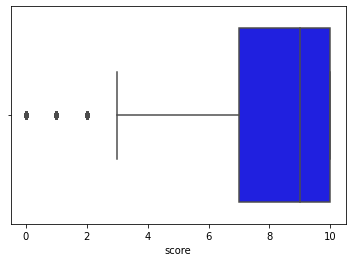

In [ ]:
# Plotting Score Coumn with Boxplot for understanding the score column

sns.boxplot(df_phones['score'],color='blue')

In [ ]:
# All Rating Types in Score Column 

df_phones['score'].value_counts()

10.0    627502
8.0     286516
2.0     123037
6.0     110118
4.0      67998
9.0      38461
7.0       8282
5.0       4378
1.0       2775
3.0       2328
0.0         42
Name: score, dtype: int64

In [ ]:
# Grouping the Dataframe based on the mean of Score column values

scores = pd.DataFrame(df_phones.groupby('product')['score'].mean())
scores.head(10)

,score
product,
"'Smartphone Meizu Pro 5, 5,7 pouces avec Exynos 7420 Octa 8 Core Processeur. mÃ©moire RAM 4 Go et 64 Go mÃ©moire...",8.000000
"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.000000
"'Sony Xperia X (F5122) â rosa â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.000000
"(7.62 cm (3 )Afficheur/Ã©cran, 2 MPixCamÃ©ra;blanc)-Smartphone",6.000000
"(CUBOT) GT88 5.5"" qHD 1.3GHz MTK6572 2-Core Android 4.2.2 3G Phone 8MP CAM 512MB RAM 4GB ROM",8.000000
"(DG300 Versione Aggiornata)5'' DOOGEE VOYAGER2 DG310 Dual Flashlights IPS Screen 3G Smartphone Android 4.4 MTK6582 1.3GHz Quad Core Telefono Cellulare Dual SIM 8G ROM OTG OTA GPS WIFI, BIANCO",7.574468
** COFFRET *** Ã©tui LG OPTIMUS L7 P700 coque LG Optimus L7 P700 Housse pour LG P700 + 3x FILM Protection LG OPTIMUS...,10.000000
*** A&D COFFRET OFFICIEL WIKO **** Housse WIKO CINK FIVE Coque wiko cink five protection Flip cover Etui ORIGINAL...,6.666667
*** COFFRET A&D *** Etui Galaxy Note 3 noir ORIGINAL Housse Samsung Galaxy NOTE 3 Coque galaxy Note 3 N9000 cuir...,10.000000


In [ ]:
# Grouping the Dataframe based on the count of each Score column values

scores['number of scores'] = df_phones.groupby('product')['score'].count()
scores.head()

,score,number of scores
product,,
"'Smartphone Meizu Pro 5, 5,7 pouces avec Exynos 7420 Octa 8 Core Processeur. mÃ©moire RAM 4 Go et 64 Go mÃ©moire...",8.0,1
"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.0,1
"'Sony Xperia X (F5122) â rosa â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.0,1
"(7.62 cm (3 )Afficheur/Ã©cran, 2 MPixCamÃ©ra;blanc)-Smartphone",6.0,1
"(CUBOT) GT88 5.5"" qHD 1.3GHz MTK6572 2-Core Android 4.2.2 3G Phone 8MP CAM 512MB RAM 4GB ROM",8.0,1


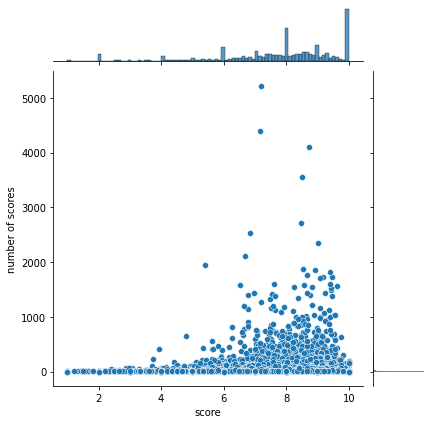

In [ ]:
# Joint Plot of Score vs Number of scores column

import matplotlib.pyplot as plt
%matplotlib inline

sns.jointplot(x='score', y= 'number of scores', data = scores)

In [ ]:
# Sort the Dataframe based on 'Number of Scores' column values

scores.sort_values('number of scores', ascending = False).head(10)

,score,number of scores
product,,
"Lenovo Vibe K4 Note (White,16GB)",7.180165,5223
"Lenovo Vibe K4 Note (Black, 16GB)",7.173388,4389
"OnePlus 3 (Graphite, 64 GB)",8.725323,4103
"OnePlus 3 (Soft Gold, 64 GB)",8.502109,3557
Huawei P8lite zwart / 16 GB,8.457702,2707
"Lenovo Vibe K5 (Gold, VoLTE update)",6.856354,2534
Samsung Galaxy S6 zwart / 32 GB,9.002135,2342
"Lenovo Vibe K5 (Grey, VoLTE update)",6.678368,2108
"Lenovo Used Lenovo Zuk Z1 (Space Grey, 64GB)",5.386981,1951


In [ ]:
scores.shape

(54872, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


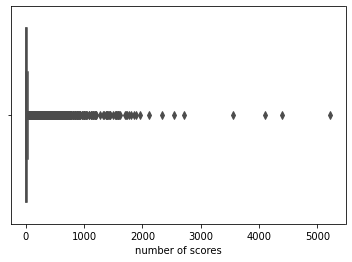

In [ ]:
sns.boxplot(scores['number of scores'],color='blue')

In [ ]:
# Subset of the dataset Dataframe where 'Number of Scores' column values are greater than 1000

scores_above_1000 = scores[scores['number of scores']>1000]
scores_above_1000.shape
print(scores_above_1000['number of scores'].sum())

90559


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


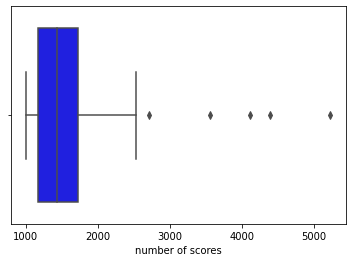

In [ ]:
sns.boxplot(scores_above_1000['number of scores'],color='blue')

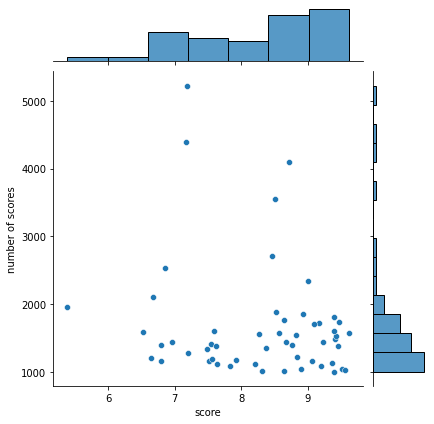

In [ ]:
sns.jointplot(x='score', y= 'number of scores', data = scores_above_1000)

In [ ]:
# Renaming the dataset Column Names
scores_above_1000.rename(columns = {'score':'mean_score'}, inplace = True)

# Converting the datatype to dataframe
scores_above_1000 = pd.DataFrame(scores_above_1000) # , columns=['Decoded Values']
scores_above_1000.reset_index(level=0, inplace=True) # to convert the current dataframe index into column

# Combining scores above 1000 with author and product columns from the original Dataset
df_phones_scores_above_1000 = pd.merge(df_phones, scores_above_1000[['product']], on = 'product', how = 'inner')
df_phones_scores_above_1000.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(90559, 3)

In [ ]:

df_phones_scores_above_1000.head(2)

,score,author,product
0,10.0,Nemo1cedillo,Samsung Galaxy S6 edge+ 32GB (T-Mobile)
1,10.0,FadeMane,Samsung Galaxy S6 edge+ 32GB (T-Mobile)


In [ ]:
df_phones_scores_above_1000['score'].value_counts()

10.0    45913
8.0     19182
2.0      8493
6.0      6229
9.0      6154
4.0      3607
7.0       739
5.0       143
3.0        59
1.0        40
Name: score, dtype: int64

In [ ]:
# Label encoding the dataframe before building the train and test set from it

df_phones_scores_above_1000['author']= label_encoder.fit_transform(df_phones_scores_above_1000['author'])

label_encoder_1 = preprocessing.LabelEncoder()

df_phones_scores_above_1000['product']= label_encoder.fit_transform(df_phones_scores_above_1000['product'])

df_phones_scores_above_1000.head(2)

,score,author,product
0,10.0,23563,43
1,10.0,10896,43


In [ ]:
# Reducing the dataset size to save on memory consumption 

df_phones_scores_above_1000 = df_phones_scores_above_1000.astype(np.uint8)
df_phones_scores_above_1000.shape

(90559, 3)

In [ ]:
# Build the train and test sets from the SVD dataset 

df_phones_scores_above_1000_new = Dataset.load_from_df(df_phones_scores_above_1000[['author', 'product', 'score']], reader)

trainset_new = df_phones_scores_above_1000_new.build_full_trainset()
testset_new = trainset_new.build_anti_testset(fill=None)

In [ ]:
# Creating a User-Based CF model. Training and prediction

user_algo_new = KNNWithMeans(k=71, sim_options = { 'name': 'pearson_baseline', 'min_support': 100, 'user_based': True}) # 'name': 'cosine', 
user_algo_new.fit(trainset_new)
user_test_pred_new = user_algo_new.test(testset_new)
user_test_pred_new

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid=11, iid=20, r_ui=8.203105157963316, est=7.788979788749335, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=11, iid=17, r_ui=8.203105157963316, est=7.193848694042355, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=11, iid=53, r_ui=8.203105157963316, est=6.282260330055401, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=144, iid=48, r_ui=8.203105157963316, est=9.376457120524073, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=144, iid=19, r_ui=8.203105157963316, est=7.457938943138542, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=144, iid=36, r_ui=8.203105157963316, est=8.161135130666253, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=144, iid=25, r_ui=8.203105157963316, est=8.67105874526701, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=225, iid=5, r_ui=8.203105157963316, est=7.986226220871114, details={'actual_k': 71, 'was_imp

In [ ]:
# Creating a Item-Based CF model. Training and prediction'

item_algo_new = KNNWithMeans(k=71, sim_options= { 'name': 'pearson_baseline','min_support': 500, 'user_based': False }) # 
item_algo_new.fit(trainset_new)
item_test_pred_new = item_algo_new.test(testset_new)
item_test_pred_new

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid=11, iid=20, r_ui=8.203105157963316, est=8.006149832192104, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=11, iid=17, r_ui=8.203105157963316, est=6.487362758335816, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid=11, iid=53, r_ui=8.203105157963316, est=6.609871263108358, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=144, iid=48, r_ui=8.203105157963316, est=9.753956232837183, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=144, iid=19, r_ui=8.203105157963316, est=6.565012617333049, details={'actual_k': 66, 'was_impossible': False}),
 Prediction(uid=144, iid=36, r_ui=8.203105157963316, est=7.69388511049776, details={'actual_k': 55, 'was_impossible': False}),
 Prediction(uid=144, iid=25, r_ui=8.203105157963316, est=8.823628386400607, details={'actual_k': 71, 'was_impossible': False}),
 Prediction(uid=225, iid=5, r_ui=8.203105157963316, est=8.290376445084059, details={'actual_k': 71, 'was_imp

In [ ]:
# User-Based CF Model-Acuracy

print("User-based Model : Test Set")
accuracy.rmse(user_test_pred_new, verbose=True)

User-based Model : Test Set
RMSE: 1.0049


1.0049360007818677

In [ ]:
# Item-Based CF Model-Acuracy

print("Item-based Model : Test Set")
accuracy.rmse(item_test_pred_new, verbose=True)

Item-based Model : Test Set
RMSE: 1.1810


1.1809935641882887

Inferences On Test RMSE of User & Item-Based Models Post Noise Reduction Performed on the Data
------------------------------------------------------------------------
1. The RMSE came down to 1.00 for User-Based Model from the previous RMSE (before Noise Reduction) of 2.75
2. The RMSE came down to 1.18 for Item-Based Model from the previous RMSE of 2.70

Business Scenario For Popularity based Recommendation Systems
=============================================================

Used by E-commerce Websites / OTT platforms etc for the users who are new to the platform since here only the popularity of the items/movies/tracks in general on the website/application is leveraged. This is because we do not have any purchase/browse history for new users.

Business Scenario For CF based Recommendation Systems
======================================================
1. Item based CF is used in business scenarios where less number of items as compared to huge users are present in such scenarios its more stable than User based recommendaton systems. E-commerce websites like Amazon, Best Buy etc leverage it to increase their sell out. Item based however performs poorly with datasets that relate to browsing or entertainment etc where recommendations target the users and their preferences.

2. Hence user based recommendation system is used with OTT platforms, Digital music/Video services, etc where one user's rating for a movie or track is calculated based on ratings given for the same movie/music track by other users who are most similar to the user being considered. YouTube, Netflix, Spotify etc use item-item based CF.